In [11]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 4CD6-0F69

 Directory of C:\Users\parag\Downloads

06/27/2020  10:09 AM    <DIR>          .
06/27/2020  10:09 AM    <DIR>          ..
06/27/2020  08:32 AM    <DIR>          .ipynb_checkpoints
06/27/2020  08:15 AM       488,908,696 Anaconda3-2020.02-Windows-x86_64.exe
06/27/2020  08:46 AM     2,565,595,880 cuda_10.1.243_426.00_win10.exe
06/27/2020  09:12 AM    <DIR>          cudnn-10.1-windows10-x64-v7.6.5.32
06/27/2020  08:47 AM       276,687,143 cudnn-10.1-windows10-x64-v7.6.5.32.zip
06/27/2020  08:50 AM    <DIR>          jigsaw-multilingual-toxic-comment-classification
06/27/2020  10:09 AM            42,965 toxic-speech (1).ipynb
06/27/2020  08:14 AM         1,406,760 vs_community__1638058066.1593245676.exe
               5 File(s)  3,332,641,444 bytes
               5 Dir(s)  67,059,408,896 bytes free


In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [9]:
# Detect hardware, return appropriate distribution strategy

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [12]:
train = pd.read_csv('./jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('./jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('./jigsaw-multilingual-toxic-comment-classification/test.csv')

In [13]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate'],axis=1,inplace=True)

In [15]:
train.shape

(223549, 3)

In [16]:
train['comment_text'].apply(lambda x:len(str(x).split())).max()

2321

In [17]:
train.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [18]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
  
    return roc_auc

In [20]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [21]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [23]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('./glove.840B.300d/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [04:49, 7579.35it/s]

Found 2196016 word vectors.


In [24]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 300257/300257 [00:00<00:00, 387733.58it/s]


GRU_training

In [25]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
     model = Sequential()
     model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 300)         90077400  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1500, 300)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 90,618,601
Trainable params: 541,201
Non-trainable params: 90,077,400
_________________________________________________________________
Wall time: 2.76 s


In [27]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=128*strategy.num_replicas_in_sync)

C:\ProgramData\Anaconda3\envs\toxic\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/5
178839/178839 [==============================] - 2068s 12ms/step - loss: 0.1270 - accuracy: 0.9505
Epoch 2/5
178839/178839 [==============================] - 2074s 12ms/step - loss: 0.1071 - accuracy: 0.9566
Epoch 3/5
178839/178839 [==============================] - 2077s 12ms/step - loss: 0.1009 - accuracy: 0.9587
Epoch 4/5
178839/178839 [==============================] - 2074s 12ms/step - loss: 0.0936 - accuracy: 0.9620
Epoch 5/5
178839/178839 [==============================] - 2073s 12ms/step - loss: 0.0862 - accuracy: 0.9647


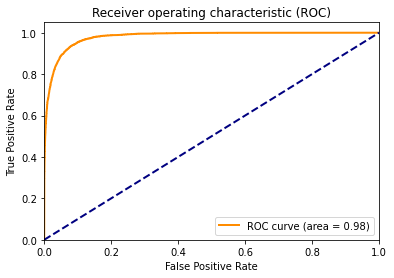

In [29]:
scores = model.predict(xvalid_pad)
GRU_score = roc_auc(scores,yvalid)

In [31]:
scores_model = []
scores_model.append({'Model': 'GRU','AUC_Score': GRU_score})
print(GRU_score)

0.9801054016967288


In [32]:
model.save('GRU_model.h5') 

Bidirectional RNN

In [34]:
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1500, 300)         90077400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 601       
Total params: 91,520,401
Trainable params: 1,443,001
Non-trainable params: 90,077,400
_________________________________________________________________


In [40]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=64*strategy.num_replicas_in_sync)

C:\ProgramData\Anaconda3\envs\toxic\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/5
178839/178839 [==============================] - 6654s 37ms/step - loss: 0.1348 - accuracy: 0.9482
Epoch 2/5
178839/178839 [==============================] - 6653s 37ms/step - loss: 0.1135 - accuracy: 0.9546
Epoch 3/5
178839/178839 [==============================] - 6649s 37ms/step - loss: 0.1060 - accuracy: 0.9574
Epoch 4/5
178839/178839 [==============================] - 6659s 37ms/step - loss: 0.1010 - accuracy: 0.9584
Epoch 5/5
178839/178839 [==============================] - 6644s 37ms/step - loss: 0.0960 - accuracy: 0.9606


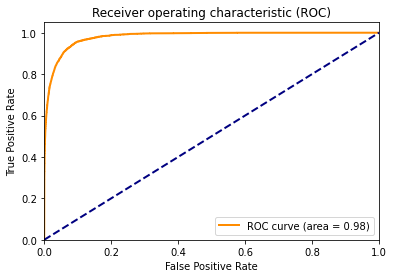

0.9802418744608898


In [41]:
scores = model.predict(xvalid_pad)
BRNN_score = roc_auc(scores,yvalid)
scores_model.append({'Model': 'BRNN','AUC_Score': BRNN_score})
print(BRNN_score)

In [42]:
model.save('BRNN_model.h5') 

LSTM model

In [43]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1500, 300)         90077400  
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 90,237,901
Trainable params: 160,501
Non-trainable params: 90,077,400
_________________________________________________________________
Wall time: 1.07 s


In [44]:
model.fit(xtrain_pad, ytrain, nb_epoch=5, batch_size=256*strategy.num_replicas_in_sync)

C:\ProgramData\Anaconda3\envs\toxic\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/5
178839/178839 [==============================] - 886s 5ms/step - loss: 0.1545 - accuracy: 0.9415
Epoch 2/5
178839/178839 [==============================] - 889s 5ms/step - loss: 0.1193 - accuracy: 0.9523
Epoch 3/5
178839/178839 [==============================] - 884s 5ms/step - loss: 0.1110 - accuracy: 0.9554
Epoch 4/5
178839/178839 [==============================] - 886s 5ms/step - loss: 0.1069 - accuracy: 0.9569
Epoch 5/5
178839/178839 [==============================] - 883s 5ms/step - loss: 0.1034 - accuracy: 0.9583


In [ ]:
scores = model.predict(xvalid_pad)
LSTM_score = roc_auc(scores,yvalid)
scores_model.append({'Model': 'LSTM','AUC_Score': LSTM_score})
print(LSTM_score)

In [ ]:
model.save('LSTM_model.h5') 

In [ ]:
# Visualization of Results obtained from various Deep learning models (RUN in the end)
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

In [ ]:
# Visualization of Results obtained from various Deep learning models (RUN in the end)
fig = go.Figure(go.Funnelarea(
    text =results.Model,
    values = results.AUC_Score,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()